In [1]:
import numpy as np
import matplotlib.pyplot as plt

n_of_each_class = 200
n_noise_of_each_class = 10

mu_pos_1 = 9
sigma_pos_1 = 0.95

mu_pos_2 = 9
sigma_pos_2 = 0.62

mu_neg_1 = 11
sigma_neg_1 = 0.95

mu_neg_2 = 11
sigma_neg_2 =  0.62

# Generate positive samples i.e., 
# x_pos_1 from N(mu_pos_1, sigma_pos_1)
x_pos_1 = np.random.normal(mu_pos_1, sigma_pos_1, n_of_each_class-2*n_noise_of_each_class)
# x_pos_2 from N(mu_pos_2, sigma_pos_2)  
x_pos_2 = np.random.normal(mu_pos_2, sigma_pos_2, n_of_each_class-2*n_noise_of_each_class)

# Generate negative samples i.e., 
# x_neg_1 from N(mu_neg_1, sigma_neg_1)
x_neg_1 = np.random.normal(mu_neg_1, sigma_neg_1, n_of_each_class-2*n_noise_of_each_class)
# x_neg_2 from N(mu_neg_2, sigma_neg_2)  
x_neg_2 = np.random.normal(mu_neg_2, sigma_neg_2, n_of_each_class-2*n_noise_of_each_class)


# Generate noise samples
x_pos_noise_1 = np.random.normal((mu_neg_1+mu_pos_1)/2, sigma_neg_1, n_noise_of_each_class)
x_pos_noise_2 = np.random.normal((mu_neg_2+mu_pos_2)/2, sigma_neg_2, n_noise_of_each_class)
x_neg_noise_1 = np.random.normal((mu_neg_1+mu_pos_1)/2, sigma_pos_1, n_noise_of_each_class)
x_neg_noise_2 = np.random.normal((mu_neg_2+mu_pos_2)/2, sigma_pos_2, n_noise_of_each_class)

x_pos_1 = np.concatenate((x_pos_1, x_neg_noise_1))
x_pos_2 = np.concatenate((x_pos_2, x_neg_noise_2))
x_neg_1 = np.concatenate((x_neg_1, x_pos_noise_1))
x_neg_2 = np.concatenate((x_neg_2, x_pos_noise_2))


pos_samples = np.stack((x_pos_1, x_pos_2, np.ones(n_of_each_class-n_noise_of_each_class), np.zeros(n_of_each_class-n_noise_of_each_class)), axis=1)
neg_samples = np.stack((x_neg_1, x_neg_2, np.zeros(n_of_each_class-n_noise_of_each_class), np.zeros(n_of_each_class-n_noise_of_each_class)), axis=1)

pos_noise_samples = np.stack((x_pos_noise_1, x_pos_noise_2, np.ones(n_noise_of_each_class), np.ones(n_noise_of_each_class)), axis = 1)
neg_noise_samples = np.stack((x_neg_noise_1, x_neg_noise_2, np.zeros(n_noise_of_each_class), np.ones(n_noise_of_each_class)), axis = 1)

samples = np.concatenate((pos_samples, neg_samples, pos_noise_samples, neg_noise_samples))

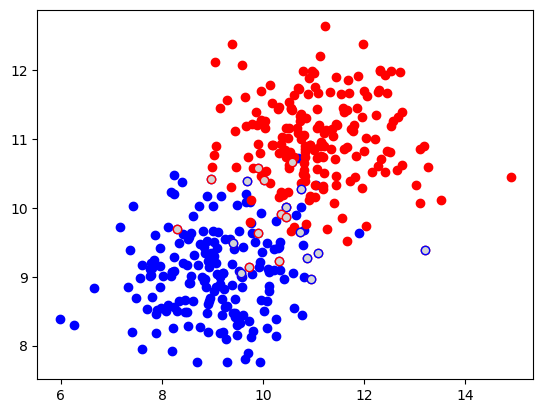

In [2]:
#Hightligthing noises
fig, ax = plt.subplots()
for i in range(len(samples)):
    fc = None
    if samples[i][3] == 1:
        fc ="lightgrey"   
    if samples[i][2] == 1:
        c = 'b'
    else:
        c = 'r'
    ax.scatter(samples[i][0], samples[i][1], color=c, facecolor=fc)

In [3]:
X = np.stack((samples[:, 0], samples[:, 1]), axis=1)
y = samples[:, 2]

X_DS = []
Y_DS = []
H_D = list()

from sklearn.model_selection import train_test_split

def samplingDataSets(n_ds = 10, ds_size = 30):
    global X_DS
    X_DS.clear()
    global Y_DS
    Y_DS.clear()
    global H_D
    H_D.clear()
    for i in range(n_ds):
        X_ds, X_not_ds, y_ds, y_not_ds = train_test_split(X, y, test_size=(len(X)-ds_size)/len(X))
        X_DS.append(X_ds)
        Y_DS.append(y_ds)

def rounding(z):
    if z <=0.5:
        return 0
    else:
        return 1

def getErrorDecomposition(L=1, n_classifiers = 10, ds_size = 30, debug=False):
    global X
    global y
    global X_DS
    global Y_DS
    global H_D
    H_D.clear()
    H_bar_x = {}
    var_x = {}
    y_bar = {}
    noise = 0
    var = 0
    bias = 0
    total_error = 0

    from sklearn import svm

    for i in range(n_classifiers):
        h_D = svm.SVC(C=1/L)
        #h_D = svm.LinearSVC(C=1/L)
        h_D.fit(X_DS[i], Y_DS[i])
        H_D.append(h_D)
    for i in range(len(X)):
        H_bar_x[i] = 0
        var_x[i] = 0
    for i in range(len(X)):
        err = 0
        for j in range(n_classifiers):
            #print(H_D[j].predict([X[i]]), end='')
            H_bar_x[i] += H_D[j].predict([X[i]])*(1/n_classifiers)
            r = ((H_D[j].predict([X[i]])[0] - y[i])**2)*(1/n_classifiers)*(1/len(X))
            #print(r)
            err += r
        #print(H_bar_x[i])
        #err /= n_classifiers
        #H_bar_x[i] /= n_classifiers
        #print(H_bar_x[i])
        total_error += err
    total_error
    for i in range(len(X)):
        #avg_h_D_x_sq = 0
        for j in range(n_classifiers):
            var_x[i] += ((H_D[j].predict([X[i]])[0] - H_bar_x[i])**2)
            #avg_h_D_x_sq += (H_D[j].predict([X[i]])[0]**2)
            if debug:
                print((H_D[j].predict([X[i]])[0] - H_bar_x[i])**2, end=" ")
        #avg_h_D_x_sq /= n_classifiers
        #var_x[i] = avg_h_D_x_sq - ((H_bar_x[i])**2)
        var_x[i] *= 1/n_classifiers
        
        if debug:
            print(var_x[i])
        var += var_x[i]
    var /= len(X)
    for i in range(len(X)):
        k = tuple(X[i].tolist())
        if k not in y_bar:
            y_bar[k] = y[i]
        else:
            y_bar[k] += y[i]
            y_bar[k] /= 2
    #for key in y_bar:
    #    y_bar[key] = int(round(y_bar[key]))
    for i in range(len(X)):
        k = tuple(X[i].tolist())
        noise += ((y_bar[k]-y[i])**2)*(1/len(X))
    #noise /= len(X)

    for i in range(len(X)):
        k = tuple(X[i].tolist())
        bias += ((y_bar[k]-H_bar_x[i])**2)*(1/len(X))
        #print(y_bar[k], H_bar_x[i])

    return total_error, var, bias, noise

In [4]:
n_sampling = 10
ds_size = 100
samplingDataSets(n_sampling, ds_size)
for i in range(-10, 10):
    L = 10**i
    total_error, var, bias, noise = getErrorDecomposition(L, n_sampling, ds_size, debug=False)
    print("Regularization with lambda = 10^%d => total error = %f; variance = %f; bias = %f; noise = %f" % (i, total_error, var, bias, noise))
    #print(total_error, var, bias, noise)


Regularization with lambda = 10^-10 => total error = 0.132750; variance = 0.072775; bias = 0.034975; noise = 0.025000
Regularization with lambda = 10^-9 => total error = 0.132500; variance = 0.072700; bias = 0.034800; noise = 0.025000
Regularization with lambda = 10^-8 => total error = 0.131250; variance = 0.071425; bias = 0.034825; noise = 0.025000
Regularization with lambda = 10^-7 => total error = 0.123500; variance = 0.066950; bias = 0.031550; noise = 0.025000
Regularization with lambda = 10^-6 => total error = 0.121500; variance = 0.065750; bias = 0.030750; noise = 0.025000
Regularization with lambda = 10^-5 => total error = 0.117250; variance = 0.061775; bias = 0.030475; noise = 0.025000
Regularization with lambda = 10^-4 => total error = 0.110250; variance = 0.051425; bias = 0.033825; noise = 0.025000
Regularization with lambda = 10^-3 => total error = 0.101750; variance = 0.040975; bias = 0.035775; noise = 0.025000
Regularization with lambda = 10^-2 => total error = 0.090750; v